# RHESSI (Reuven Ramaty High Energy Solar Spectroscopic Imager)
### Estudio de las llamaradas solares 
##### Descripcion:
Durante una llamarada, el gas situado en la atmósfera solar alcanza temperaturas de hasta 11 millones de grados Celsius, acelerando particulas a velocidades muy altas en el proceso. Esta aceleración ocasiona emisiones de luz en un rango que va desde el visible hasta rayos gamma, en donde dicha radiación no es apta para penetrar la atmósfera terrestre y por lo tanto no puede ser medida desde la tierra. Para poder registrar estas llamaradas y sus emisiones, se desarrolló la misión RHESSI mediante la creación de un satélite que midiera esta radiación y de esta manera lograr enteder el comportamiento de las llamaradas. El instrumento combina imagenes espectroscópicas del sol para caracterizar las energías presentes en cada llamarada. 

### Primer acercamiento con los datos
Para iniciar, se tomó la base de datos de la misión RHESSI de la NASA desde la página Kaggle [Solar Flares from RHESSI Mission](https://www.kaggle.com/datasets/khsamaha/solar-flares-rhessi) directamente como un archivo CSV. En esta página se encuentran 2 archivos referentes a los intervalos 2002-1016 y 2002-2018, pero en el estudio se considera el archivo con los datos completos (2002-2018).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

# Se está trabajando en la rama testgh by @SOG


Para limpiar un poco la base de datos, se realiza una unión entre las columnas que contienen información acerca de la fecha y hora de inicio de la erupción, para generar una columna ***DateTime*** que luego se convierte en el index de los datos y descartar entonces la columna ***flare***. Luego, se crean nuevas columnas que guardan información como la energía promedio y la energía máxima a partir de ***energy.kev***, que facilitarán el ordenamiento de los datos cuando este se requiera. Además, como mecanismo de filtración, se crea una función la cual recibe un *DataFrame* y una lista que tiene como elementos las banderas que se quieren omitir de los datos, para retornar un *DataFrame* sin los eventos asociados a las banderas establecidas. Lo anterior con el objetivo de filtrar los datos para tomar solo los eventos asociados a procesos solares, cuando esto sea necesario. 

In [2]:
file_path = r"2002to2018.csv"  #2002to2016.csv
df = pd.read_csv(file_path)
# df = df.sort_values(by='duration.s', ascending=False).reset_index(drop=True)
# formatT = '%Y-%m-%d %H:%M:%S'

df['Datetime'] = pd.to_datetime(df['start.date'] +
                                ' ' + 
                                df['start.time'])
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
del df['flare']
del df['start.date']
del df['start.time']
del df['Datetime']

## CALCULO DE ENERGIAS

Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Eprom.append((float(result[0]) + float(result[1]))/2)

df['Emax.kev'] = Emax
df['Eprom.kev'] = Eprom



def filtro(data, Lbanderas): # Filtro por bandera, se podría agregar que eliminara también el rango de energía 3-6 keV
    for bandera in Lbanderas: 
        ## filter
        data = data[data['flag.1'] != bandera]
        
        data = data[data['flag.2'] != bandera]

        data = data[data['flag.3'] != bandera]
        
        data = data[data['flag.4'] != bandera]

        values = data['flag.5'].values
        lfilter = [i for i in list(values[pd.notnull(values)]) if bandera in i]
        data = data[~data['flag.5'].isin(lfilter)]
            
    return data
df

,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5,Emax.kev,Eprom.kev
Datetime,,,,,,,,,,,,,,,,,
2002-02-12 21:29:56,21:33:38,21:41:48,712,136,167304.0,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN,25.0,18.5
2002-02-12 21:44:08,21:45:06,21:48:56,288,7,9504.0,6-12,604,-341,694,9811,A1,P1,PE,Q1,NaN,12.0,9.0
2002-02-13 00:53:24,00:54:54,00:57:00,216,15,11448.0,6-12,-310,375,487,9825,A1,P1,NaN,NaN,NaN,12.0,9.0
2002-02-13 04:22:52,04:23:50,04:26:56,244,20,17400.0,12-25,-277,378,469,9822,A1,P1,NaN,NaN,NaN,25.0,18.5
2002-02-13 07:03:52,07:05:14,07:07:48,236,336,313392.0,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2,50.0,37.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-09 16:41:28,16:42:54,16:43:32,124,18,2888.0,6-12,-345,-38,347,2699,A0,DF,P1,PE,Q2,12.0,9.0
2018-02-09 18:15:56,18:17:26,18:17:40,104,16,1656.0,6-12,-268,-38,271,2699,A0,DF,P1,PE,Q2,12.0,9.0
2018-02-10 13:04:36,13:06:46,13:07:04,148,15,2224.0,6-12,-115,-38,121,2699,A0,DF,P1,PE,Q2,12.0,9.0


### Análisis de datos
Como primer análisis a los datos, se busca estudiar si existe alguna relación lineal entre las columnas involucradas en la base de datos, y es por ello que se realiza una matriz de correlación. Esta matriz arroja como resultado un comportamiento no lineal y se descarta un estudio de este tipo para las columnas de la base de datos.

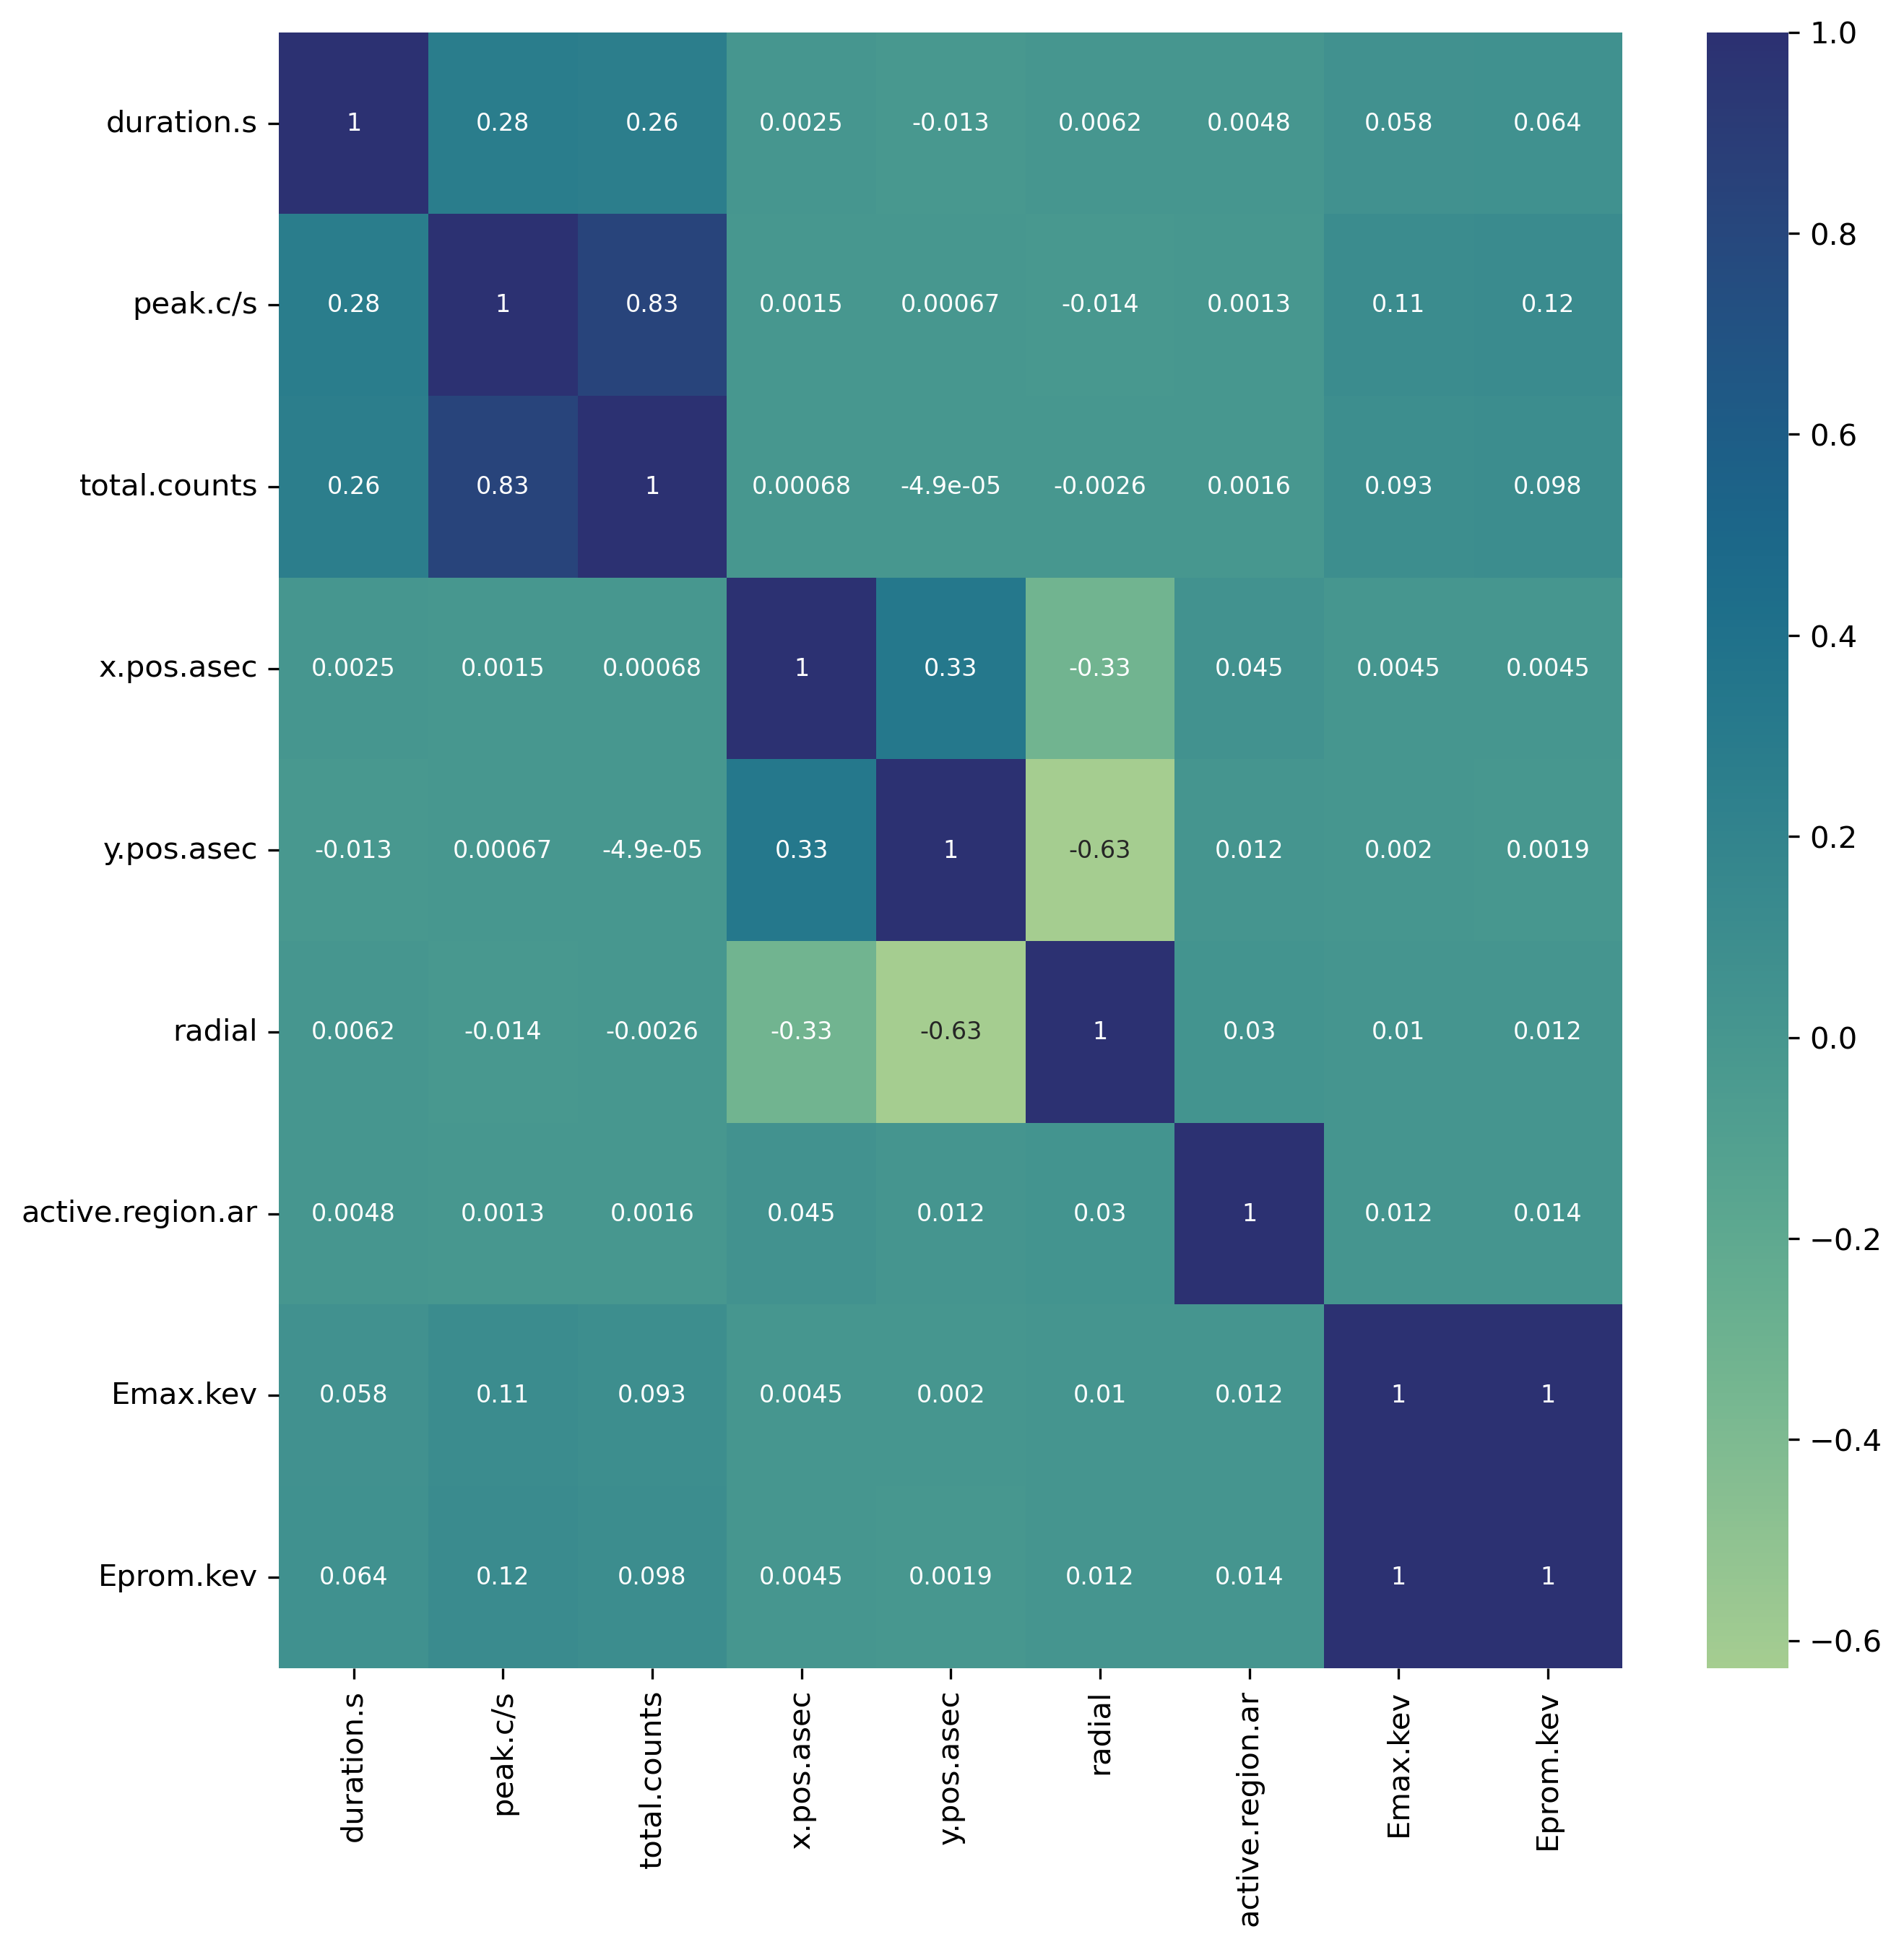

In [8]:
plt.figure(figsize=(10,10), dpi = 300)
matriz=df.corr(method='pearson')
sns.heatmap(matriz,cmap='crest',annot=True, annot_kws={'fontsize':8})
plt.savefig('matriz.png', dpi=300)

### Histogramas
##### Se muestra la distribución de las erupciones en la superficie solar junto al histograma de la posición para cada ***(x,y)***


C:\Users\santi\AppData\Local\Temp\ipykernel_25868\735006098.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('G1.png', dpi = 300)


ok


C:\Users\santi\anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


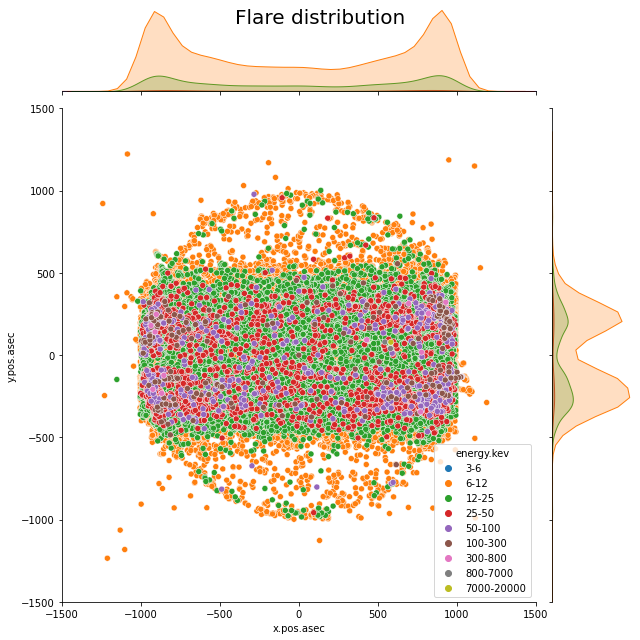

In [234]:
sns.jointplot(data=df.sort_values('Eprom.kev'), x='x.pos.asec', y='y.pos.asec', hue='energy.kev', kind='scatter', height=9, 
              xlim=(-1500, 1500), ylim=(-1500, 1500)).fig.suptitle('Flare distribution', fontsize=20)
plt.savefig('G1.png', dpi = 300)
print('ok')

#### Histograma de rango de energías

<AxesSubplot:xlabel='energy.kev', ylabel='count'>

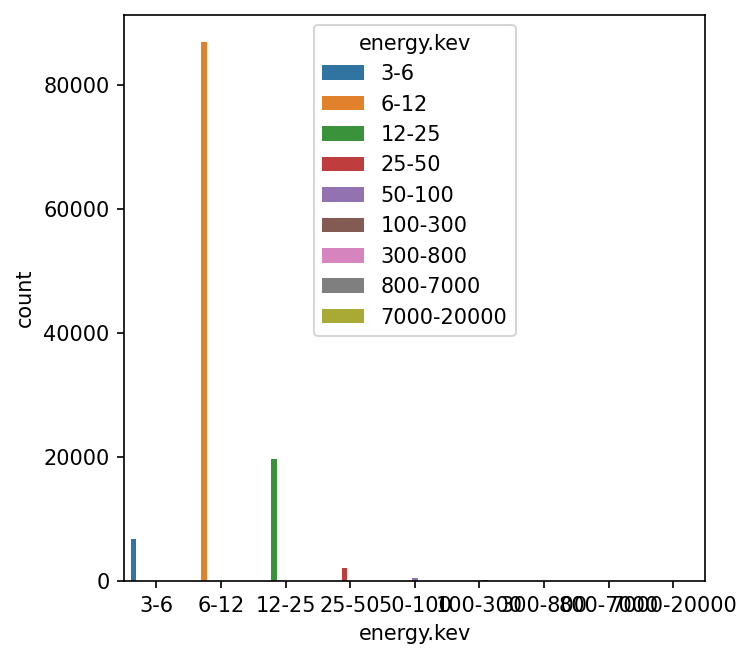

In [235]:
#### To Do: Estadística con los datos

energy = df['energy.kev'] == '12-25' # Se filtra por rango de energias
dfenergy = df[energy]

datos = dfenergy['y.pos.asec'] 
datos.describe()


plt.figure(figsize=(5,5), dpi = 150)
sns.countplot(data=df.sort_values('Eprom.kev'), x="energy.kev", hue='energy.kev')
# df.describe()

,duration.s,peak.c/s,total.counts,x.pos.asec,y.pos.asec,radial,active.region.ar,Emax.kev,Eprom.kev
count,116143.000000,116143.000000,1.161430e+05,116143.000000,116143.000000,116143.000000,116143.000000,116143.000000,116143.000000
mean,493.643009,215.086617,3.768843e+05,-7.681625,-42.185495,687.896989,990.071550,15.798257,11.718171
std,434.131763,839.382841,3.048797e+06,755.773503,401.904509,511.364382,1351.853636,67.634900,44.361745
min,8.000000,0.000000,8.000000e+00,-10012.000000,-10005.000000,0.000000,0.000000,6.000000,4.500000
25%,212.000000,28.000000,2.284000e+04,-701.000000,-247.000000,467.000000,0.000000,12.000000,9.000000
50%,364.000000,56.000000,5.856000e+04,0.000000,-71.000000,759.000000,691.000000,12.000000,9.000000
75%,628.000000,144.000000,1.798080e+05,708.000000,198.000000,946.000000,1564.000000,12.000000,9.000000
max,4444.000000,113156.000000,4.355501e+08,1190.000000,1223.000000,14154.000000,9999.000000,20000.000000,13500.000000


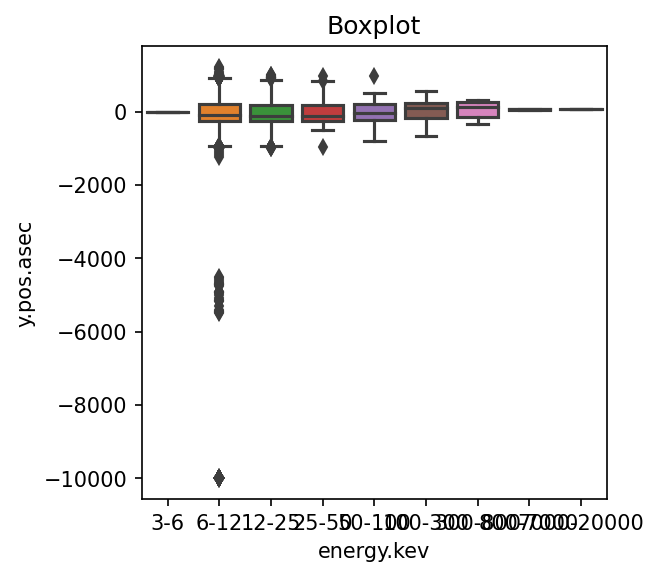

In [236]:
plt.figure(figsize=(4,4), dpi = 150)
sns.boxplot(data=df.sort_values('Eprom.kev'), x='energy.kev', y="y.pos.asec")
plt.title('Boxplot')
df.describe()

<AxesSubplot:xlabel='log(duration.s)', ylabel='Count'>

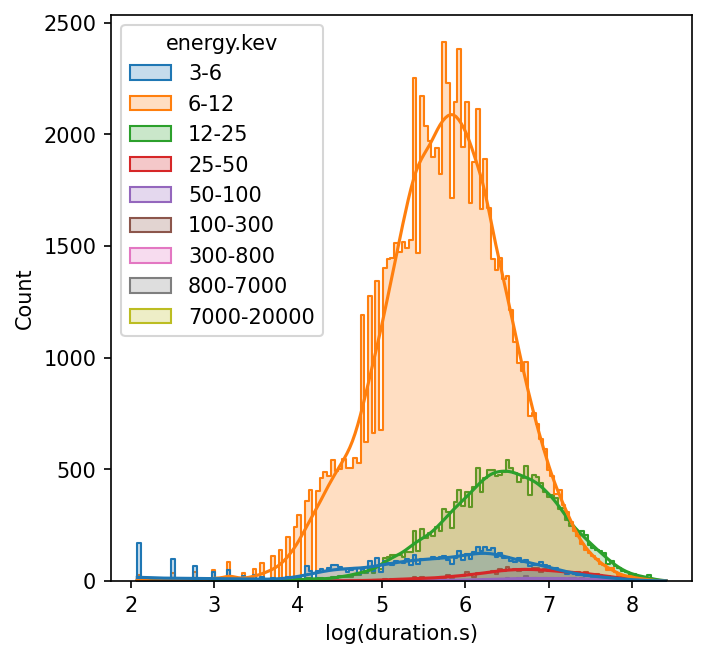

In [237]:
df['log(duration.s)'] = np.log(df['duration.s'])

plt.figure(figsize=(5,5), dpi = 150)
sns.histplot(data=df.sort_values('Eprom.kev'), x='log(duration.s)', hue='energy.kev', element="step", kde=True)
# plt.xlabel('log(duration.s)')
# plt.legend(df.value_counts('energy.kev', ascending=True).index, loc = 'upper left')

C:\Users\santi\anaconda\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


,duration.s,peak.c/s,total.counts,x.pos.asec,y.pos.asec,radial,active.region.ar,Emax.kev,Eprom.kev,log(duration.s)
count,116143.000000,116143.000000,1.161430e+05,116143.000000,116143.000000,116143.000000,116143.000000,116143.000000,116143.000000,116143.000000
mean,493.643009,215.086617,3.768843e+05,-7.681625,-42.185495,687.896989,990.071550,15.798257,11.718171,5.876659
std,434.131763,839.382841,3.048797e+06,755.773503,401.904509,511.364382,1351.853636,67.634900,44.361745,0.838296
min,8.000000,0.000000,8.000000e+00,-10012.000000,-10005.000000,0.000000,0.000000,6.000000,4.500000,2.079442
25%,212.000000,28.000000,2.284000e+04,-701.000000,-247.000000,467.000000,0.000000,12.000000,9.000000,5.356586
50%,364.000000,56.000000,5.856000e+04,0.000000,-71.000000,759.000000,691.000000,12.000000,9.000000,5.897154
75%,628.000000,144.000000,1.798080e+05,708.000000,198.000000,946.000000,1564.000000,12.000000,9.000000,6.442540
max,4444.000000,113156.000000,4.355501e+08,1190.000000,1223.000000,14154.000000,9999.000000,20000.000000,13500.000000,8.399310


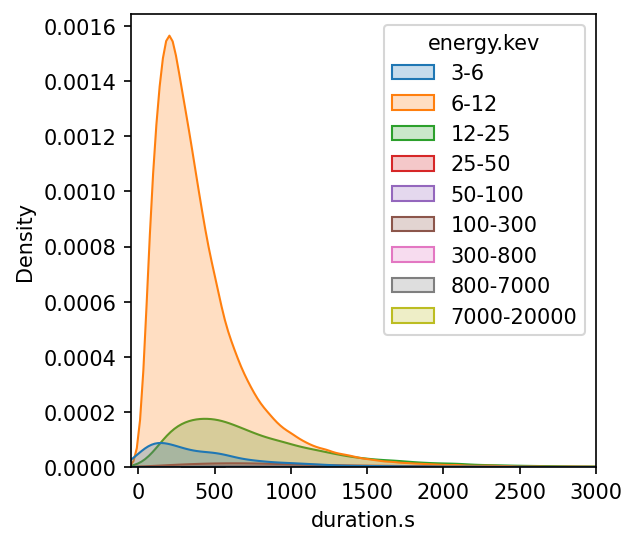

In [238]:
plt.figure(figsize=(4,4), dpi = 150)
sns.kdeplot(data=df.sort_values('Eprom.kev'), x='duration.s', hue='energy.kev', fill=True)
plt.xlim(-50,3000)
df.describe()

Text(0.5, 1.0, 'Boxplot')

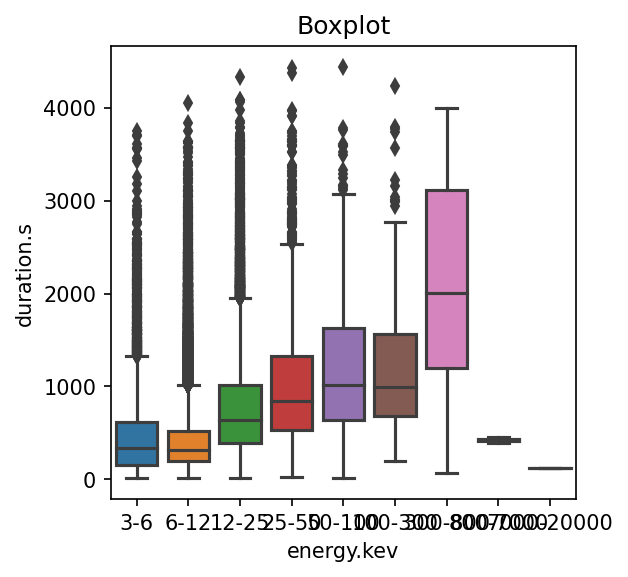

In [239]:
plt.figure(figsize=(4,4), dpi = 150)
sns.boxplot(data=df.sort_values('Eprom.kev'), x='energy.kev', y="duration.s")
plt.title('Boxplot')
# df.describe()

C:\Users\santi\anaconda\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


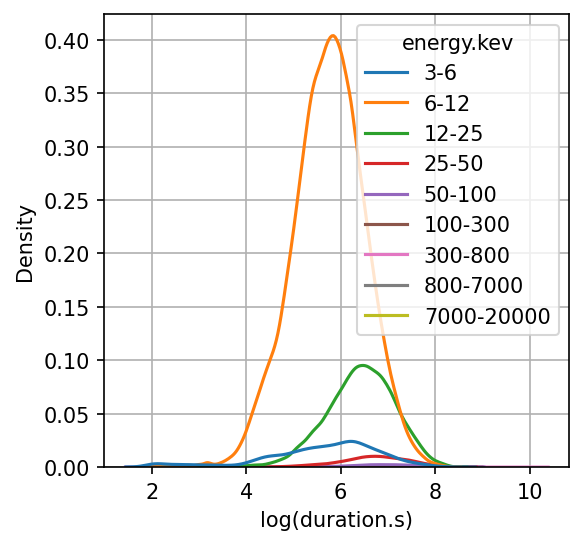

In [266]:
plt.figure(figsize=(4,4), dpi = 150)

# df['duration.ls'] = np.log(df['duration.s'])
sns.kdeplot(data=df.sort_values('Eprom.kev'), x='log(duration.s)', hue='energy.kev') 
plt.grid()

### Datos nulos y filtrado
##### Se filtran los posibles valores erróneos de acuerdo a las banderas establecidas en el archivo README, o eventos no ocurridos en el sol

peak                    0
end                     0
duration.s              0
peak.c/s                0
total.counts            0
energy.kev              0
x.pos.asec              0
y.pos.asec              0
radial                  0
active.region.ar        0
flag.1                  0
flag.2                  0
flag.3              19907
flag.4              20202
flag.5              61180
Emax.kev                0
Eprom.kev               0
log(duration.s)         0
dtype: int64

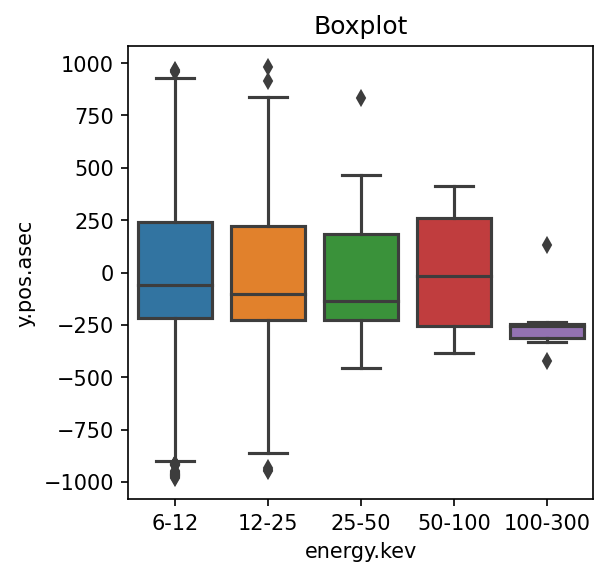

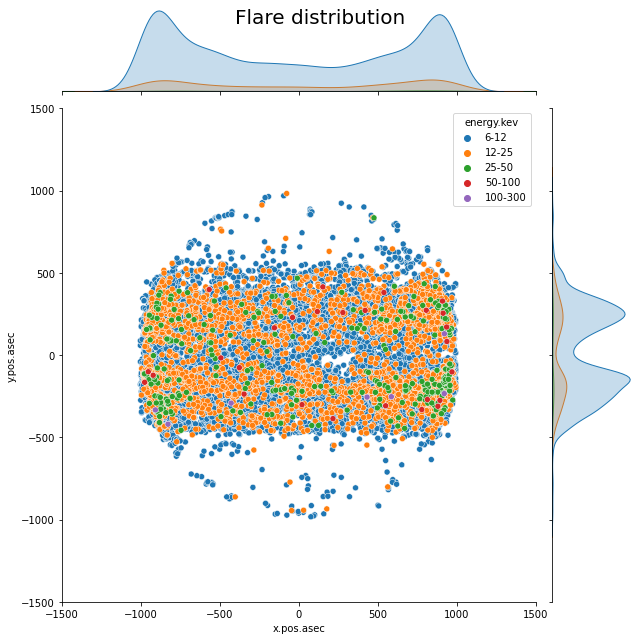

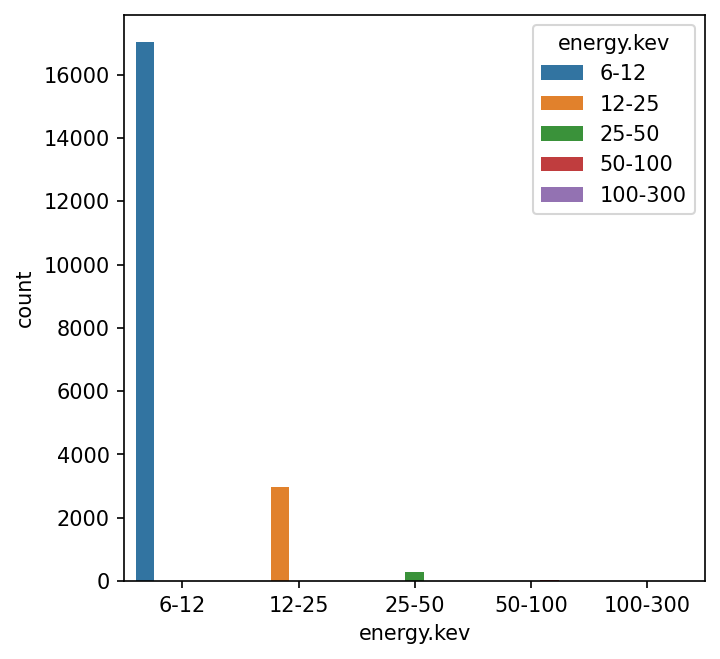

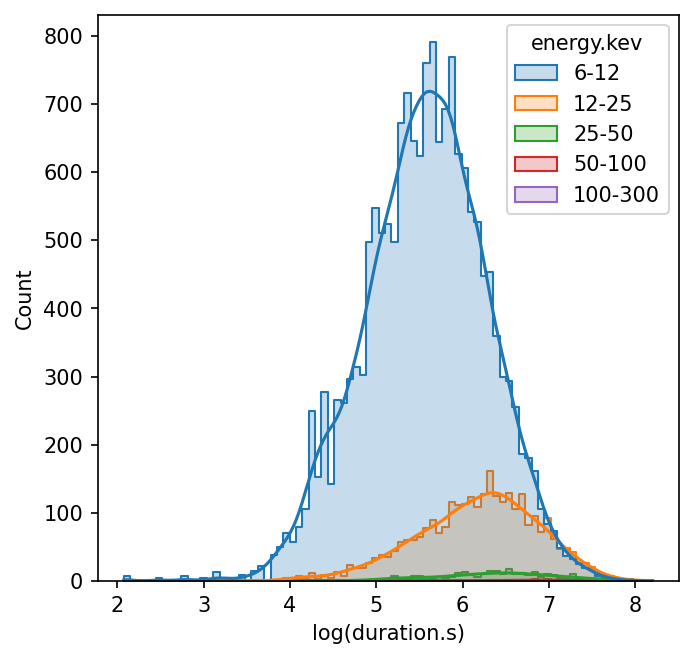

In [241]:
lista = ['NS','SD','SS','DF','DR','ED','ES','FE','FR','FS','GD','GE','GS','MR','P0','PS','PE']
dataFiltro = filtro(df, lista)
dataFiltro

# dataFiltro['duration.sl'] = np.log(dataFiltro['duration.s'])
# log(duration.s)

plt.figure(figsize=(4,4), dpi = 150)
sns.boxplot(data=dataFiltro.sort_values('Eprom.kev'), x='energy.kev', y="y.pos.asec")
plt.title('Boxplot')
df.describe()

sns.jointplot(data=dataFiltro.sort_values('Eprom.kev'), x='x.pos.asec', y='y.pos.asec', hue='energy.kev', kind='scatter', height=9, 
              xlim=(-1500, 1500), ylim=(-1500, 1500)).fig.suptitle('Flare distribution', fontsize=20)

plt.figure(figsize=(5,5), dpi = 150)
sns.countplot(data=dataFiltro.sort_values('Eprom.kev'), x="energy.kev", hue='energy.kev')


plt.figure(figsize=(5,5), dpi = 150)
sns.histplot(data=dataFiltro.sort_values('Eprom.kev'), x='log(duration.s)', hue='energy.kev', element="step", kde=True)
# plt.xlabel('log(duration.s)')


df.isnull().sum()

#### Aproximación utilizando una distribución normal a partir de datos logarítmicos

(6.69105805830418, 0.7236517010810419)

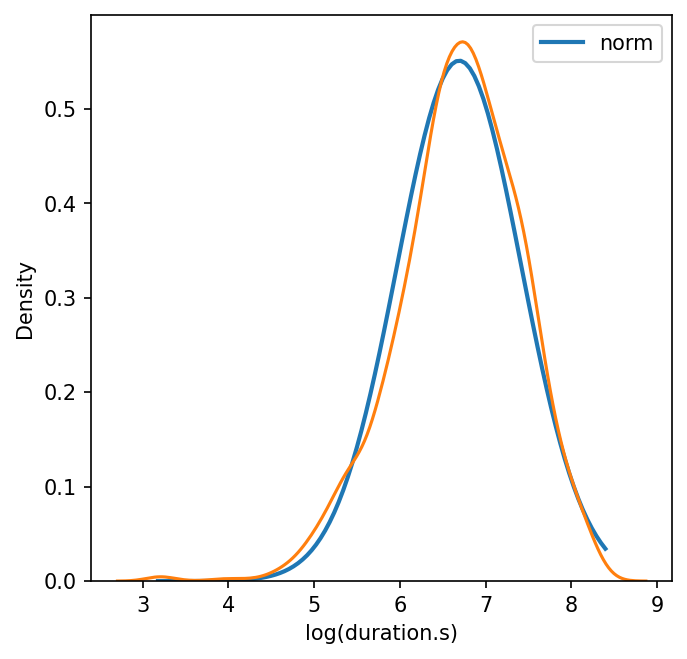

In [250]:
fil = df['energy.kev'] == '25-50' # Se filtra por rango de energias
dataF = df[fil]

distr = stats.norm

parametros = distr.fit(data=dataF['log(duration.s)'])
# nombre_parametros = [p for p in inspect.signature(distr._pdf).parameters \
#                      if not p=='x'] + ["loc","scale"]
# parametros_dict = dict(zip(nombre_parametros, parametros))

x_hat = np.linspace(min(dataF['log(duration.s)']), max(dataF['log(duration.s)']), num=100)
y_hat = distr.pdf(x_hat, *parametros)
plt.figure(figsize=(5,5), dpi = 150)
plt.plot(x_hat, y_hat, linewidth=2, label=distr.name)



# plt.figure(figsize=(5,5), dpi = 150)
sns.kdeplot(data=dataF.sort_values('Eprom.kev'), x='log(duration.s)')
plt.legend()
parametros

In [279]:
plt.figure(figsize=(4,4), dpi = 150)

fil = df['energy.kev'] == '12-25' # Se filtra por rango de energias
dataF = df[fil]

prueba = dataFiltro

sns.histplot(data=prueba, x='peak.c', y='peak.c/s', element="poly")

# sns.boxplot(data=prueba.sort_values('Eprom.kev'), x='energy.kev', y="radial")